# <center > <u> PHYC90009 Assignment </u> </center>

## <center> How much of the sky is covered by galaxies? </center> 
### <center> Mitchell de Zylva - 756539 </center>
Our aim in this report is to calculate the proportion of the sky that is covered by galaxies, through the implementation of the Press-Schechter Mass Function

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## Packages 
Numpy, Scipy, Matplotlib

In [2]:
import numpy as np
import scipy as sp
from scipy.integrate import quad, dblquad, simps,nquad, trapz
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'}
plt.rcParams['figure.dpi'] = 100

## Constants 
##### Speed of Light in m s-1
$$c = 299792458 $$
##### Reduced Hubble Const
$$h = 0.7$$ 
##### Omega for Curvature
$$\Omega_k = 0 $$
##### Omega Matter
$$\Omega_m = 0.3$$ 
##### Omega Dark Energy
$$\Omega_\lambda = 0.7$$ 
##### Omega Radiation
$$\Omega_r = 0.0$$
##### Spectral Index
$$n = 1$$ 
##### Variance at 8 MPC
$$\sigma_8 = 0.9$$
##### Gravitational Constant
$$G = 6.67 * 10^{-11}$$

In [3]:
h_0 = 67.66 #Hubble Const from Planck km s-1 Mpc-1
c = 299792458 #Speed of Light m s-1
h = 0.7 #Reduced Hubble Const
om_k = 0 #Omega for Curvature
om_m = 0.3 #Omega Matter
om_lam = 0.7 #Omega Dark Energy
om_r = 0.0 #Omega Radiation
n = 1 
sig_8 = 0.9
G = 6.67e-11 # m3 kg-1 s-2
d_h0 = c*10**(-3)/h_0 # Hubble dist at current time 


### 1) a) Compute and Plot the Angular Diamter Distance as a Function of Redshift
Angular Diamter Distance $d_A$ is given by the expression
$$ d_A = \frac{r_{em}}{1 + z}$$
Where $r_{em}$ is the comoving distance, given by 
$$ r_{em} = \int_0^z d_h dz' $$ 
z is redshift,
d_h is the Hubble Distance, given by 
$$ d_h = \frac{c}{H(z)} $$
$$ \Rightarrow d_A = \frac{c}{1+z} \int_0^z \frac{dz'}{H(z)} $$

In order to calculate this, we construct a range of redshifts, and perform an integral over the $d_h$ function for all the values, then graph the resulting array against our range of redshifts, remembering to be careful about units.


In [4]:
z = np.arange(0,30,0.1)
def d_h(z):
    return((c*10**(-3))/(h_0*np.sqrt(om_m*(1+z)**3 + om_lam)))

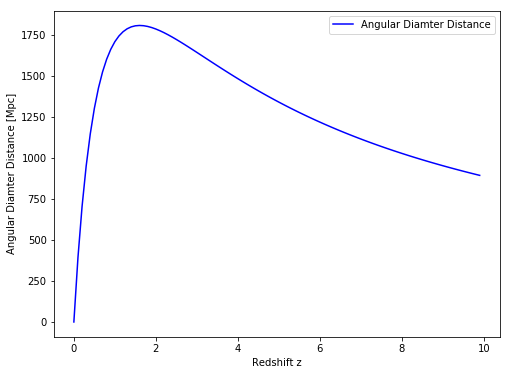

In [5]:
r_em = [(1/((1+zed))*quad(d_h,0,zed)[0]) for zed in z]
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(z[0:100],r_em[0:100],'b-',label='Angular Diamter Distance')
ax.set_xlabel('Redshift z')
ax.set_ylabel('Angular Diamter Distance [Mpc]')
ax.legend(loc = 'upper right')
#Need to Correct Units here!

### 1) b) Compute and Plot the Growth Function as a Function of Redshift
The growth function as a function of redshift is given by 
$$ D(t) \propto \frac{(\Omega_\Lambda a^3 + \Omega_k a + \Omega_m)^{1/2}}{a^{3/2}} \int_0^a \frac{a'^{3/2} da'}{(\Omega_\Lambda a'^3 + \Omega_k a' + \Omega_m)^{3/2}} $$ 
where $a = \frac{1}{1+z}$
We have already stored all our $\Omega$'s as constants, so in order to calculate the Growth Function, we need to define an integrand, as a function of a. It is simple to redefine our range of redshifts as scale factor, then we simply need to compute the integral for our range of scale factors. Given that we know the Growth function must be 1 at redshift 0, we can scale our Growth function by normalising it by the value it gives at redshift 0

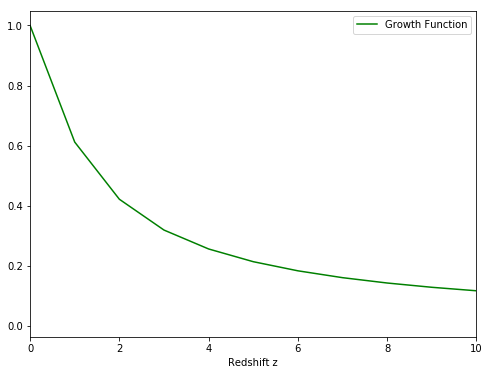

In [6]:
z = np.arange(0,100,1)
a = 1/(1+z)
# Need to Change Variables to get right results
def temp_func(a):
    return(float((a**(3./2.))/((om_lam * a**3 + om_k * a + om_m )**(3./2.))))

D_t = [np.sqrt(om_lam * ay**3 + om_k * ay + om_m )/(ay**(3/2))*quad(temp_func,0,ay)[0] for ay in a]

# Normalise D_t using z=0
D_t_norm = np.sqrt(om_lam * 1**3 + om_k * 1 + om_m )/(1**(3/2))*quad(temp_func,0,1)[0] 

D_t = D_t/D_t_norm

fig, ax = plt.subplots(figsize= (8,6))
plt.xlim(0,10)
ax.plot(z,D_t,'g-',label='Growth Function')
ax.set_xlabel('Redshift z')
ax.legend(loc = 'upper right')

## 1) c) Compute and plot the variance on a mass scale $M$ at redshift $z$
The variance of the Mass Scale is given by the expression
$$\sigma^2 (m) = \sigma^2 (R) = \frac{1}{2 \pi^2} \int_0^\infty dk k^2 P(k) \Bigg[ \frac{3 j_1(kR) }{kR} \Bigg]^2$$
Where
$$ j_1 = \frac{\sin(x) - x \cos(x) }{x^2} $$
We use an approximation to the Power Spectrum where
$$ P(k) \propto k^n T^2(k) $$ 
$$ T(k) = \frac{\ln(1+2.34q)}{2.34 q} [1+3.89q+(16.1q)^2 + (5.46q)^3 + (6.71q)^4]^{-1/4} $$
$$ q = \frac{k}{\Omega_m^z h^2} $$
$$ \Omega_m^z = \frac{\Omega_m (1+z)^3}{\Omega_m (1+z)^3 + \Omega_{\Lambda} + \Omega_k(1+z)^2}$$

In order to calculate this, the sub-factors must be calculated first, and passed through the functions in a bootstrap fashion. We also have to note that 
$$ M = \frac{4 \pi R^3 \rho_M}{3} \Rightarrow R = \Big(\frac{3 M}{4 \pi \rho_M}\Big)^{1/3}$$
All of these terms have to be calculated at $z=0$, and we evolve them to higher redshifts using the growth factor $D$

The variance is normalised by using a known parameter $\sigma_8$, which corresponds to the variance at 8 Mpc. You therefore need to scale the integral by its known value $\sigma_8$. 

In [7]:
# Density in Solar Masses per megaparsec^3
rho_crit = (3*(h_0*3.241e-20)**2)/(8*np.pi*G*6.769e-38)
rho_m = om_m*rho_crit
#Generate Mass Space
m = np.logspace(2,15,num=1000)
#Convert to Radius (Units = Mpc)
r = ((3*m)/(4*np.pi*rho_m))**(1/3)


In [8]:
def j_1(x):
    return((np.sin(x) - x* np.cos(x))/(x**2))

def q(k):
    return(k/(om_m*h**2))

def t_k(k):
    first = (np.log(1+2.34*q(k))/(2.34*q(k)))
    second = (1+3.89*q(k) + (16.1*q(k))**2 + (5.46*q(k))**3 + (6.71*q(k))**4)**(-1/4)
    return( first*second )

def P_k(k):
    return(((k * (t_k(k))**2)))

def sigma_integrand(k,r):
    return(k**2 * P_k(k) * ((3 * j_1(k*r))/(k*r))**2)

sigma_8_int = (1/(2*np.pi**2)*quad(sigma_integrand,0,np.inf,args=(8/h))[0])**(1/2)
#print(sigma_8_int)
const_s8 = 0.9/sigma_8_int
#print(const_s8)

#Perform Integral over k, passing radii to function as you go
var_z_0 = [(const_s8*(1/(2*np.pi**2)*quad(sigma_integrand,0,np.inf,args=(ar))[0])**(1/2)) for ar in r]

#Scale at higher redshifts using Growth Factor
var_z_5 = [zed*D_t[5] for zed in var_z_0]
var_z_10 = [zed*D_t[10] for zed in var_z_0]
var_z_20 = [zed*D_t[20] for zed in var_z_0]
var_z_30 = [zed*D_t[30] for zed in var_z_0]



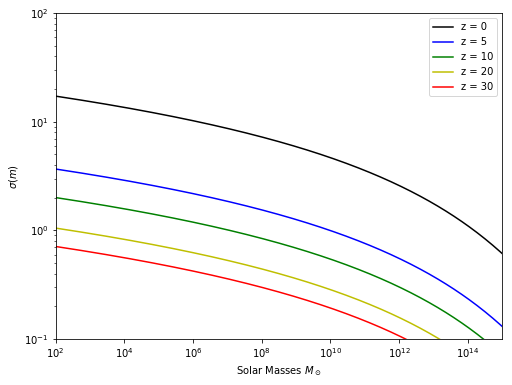

In [9]:
fig, ax = plt.subplots(figsize= (8,6))
plt.ylim(0.1,100)
ax.semilogx(m,var_z_0,'k-',label='z = 0')
ax.semilogx(m,var_z_5,'b-',label='z = 5')
ax.semilogx(m,var_z_10,'g-',label='z = 10')
ax.semilogx(m,var_z_20,'y-',label='z = 20')
ax.semilogx(m,var_z_30,'r-',label='z = 30')
#ax.plot(m,z_5,'r-',label='z = 5')
#ax.plot(k[:500],integrand(k,10,1)[:500],'b-')
#ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc = 'upper right')
ax.set_xlabel('Solar Masses $M_\odot$')
ax.set_ylabel('$\sigma(m)$')
ax.margins(x=0)


## 1) d) the Press - Schechter mass function of DM halos (at a range of redshifts)
The Press-Schechter Mass Function is given by 
$$\frac{d n_h (m,z)}{dm} = - \sqrt{\frac{2}{\pi}} \frac{\rho_m}{m} \frac{d[\log{\sigma(m)}]}{dm} \nu_c \exp\Big(-\frac{\nu_c^2}{2} \Big)$$
Where 
$$\nu_c = \delta_c (z) \sigma(m) $$
Again, $\sigma(m)$, and $\rho_m$ are calculated at $z=0$

We know that $\delta_c(z=0) = 1.69$, and we can evolve the critical density backwards using the growth factor
$$ \delta_c(z) = \frac{1.69}{D(z)}$$
We can also approximate the derivative term 
$$\frac{d[\log{\sigma(m)}]}{dm} \approx \frac{\log\sigma(m+\Delta m) - \log\sigma(m)}{\Delta m} \approx \frac{\ln\sigma(1.1m) - \ln\sigma(m)}{1.1m-m}$$ 

My method of implementation here involves utilising arrays generated from the variance, and passing their values through the functional form of the Press-Schechter to give useful values. I subsequently had to actually produce a function of this process, since it aids the calculation of the optical depth to simply have a Press-Schechter function defined. 

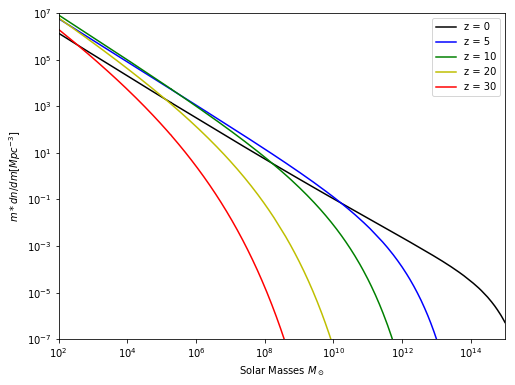

In [10]:
def d_c(z): 
    return(1.69/D_t[z])
#Initialise variational term for mass, and generate second set of R values
second_m = 1.1*m
second_r  = ((3*second_m)/(4*np.pi*rho_m))**(1/3)
#Calcualte variance at 1.1m 
var_z_0_1pt1 = [(const_s8*(1/(2*np.pi**2)*quad(sigma_integrand,0,np.inf,args=(ar))[0])**(1/2)) for ar in second_r]
#Compute Differential Term
diff_term = (np.log(var_z_0_1pt1) - np.log(var_z_0))/(second_m-m)

#Compute the Nu values for various redshifts
nu_z0 = d_c(0)/var_z_0
nu_z5 = d_c(5)/var_z_0
nu_z10 = d_c(10)/var_z_0
nu_z20 = d_c(20)/var_z_0
nu_z30 = d_c(30)/var_z_0

#Compute the ratio of masses 
dn_dm_z0 = -np.sqrt((2)/(np.pi))* rho_m/(m) * diff_term * nu_z0* np.exp(- (nu_z0)**2/2)
dn_dm_z5 = -np.sqrt((2)/(np.pi))* rho_m/(m) * diff_term * nu_z5* np.exp(- (nu_z5)**2/2)
dn_dm_z10 = -np.sqrt((2)/(np.pi))* rho_m/(m) * diff_term * nu_z10* np.exp(- (nu_z10)**2/2)
dn_dm_z20 = -np.sqrt((2)/(np.pi))* rho_m/(m) * diff_term * nu_z20* np.exp(- (nu_z20)**2/2)
dn_dm_z30 = -np.sqrt((2)/(np.pi))* rho_m/(m) * diff_term * nu_z30* np.exp(- (nu_z30)**2/2)

def press_schecter(M,z):
    
    r = ((3*M)/(4*np.pi*rho_m))**(1/3)
 #   print("r=" + str(r))

    var = (const_s8*(1/(2*np.pi**2)*quad(sigma_integrand,0,np.inf,args=(r))[0])**(1/2))
  #  print("var=" + str(var))
    second_m = 1.1*M
   # print("second_m="+str(second_m))
    second_r  = ((3*second_m)/(4*np.pi*rho_m))**(1/3)
   # print("second_r="+str(second_r))
    #Calcualte variance at 1.1m 
    var_1pt1 = (const_s8*(1/(2*np.pi**2)*quad(sigma_integrand,0,np.inf,args=(second_r))[0])**(1/2))
   # print("var1pt1="+str(var_1pt1))
    #Compute Differential Term
    diff_term = (np.log(var_1pt1) - np.log(var))/(second_m-M)
   # print("diff_term="+str(diff_term))
    #Compute the Nu values for various redshifts
    nu = d_c(z)/var
   # print("nu="+str(nu))
    #Compute the ratio of masses 
    dn_dm = -np.sqrt((2)/(np.pi))* rho_m/(M) * diff_term * nu* np.exp(- (nu)**2/2)
    return(dn_dm)

fig, ax = plt.subplots(figsize= (8,6))
plt.ylim(1e-7,1e7)
ax.semilogx(m,m*dn_dm_z0,'k-',label='z = 0')
ax.semilogx(m,m*dn_dm_z5,'b-',label='z = 5')
ax.semilogx(m,m*dn_dm_z10,'g-',label='z = 10')
ax.semilogx(m,m*dn_dm_z20,'y-',label='z = 20')
ax.semilogx(m,m*dn_dm_z30,'r-',label='z = 30')
ax.set_yscale("log")
ax.legend(loc = 'upper right')
ax.set_xlabel('Solar Masses $M_\odot$')
ax.set_ylabel('$m*dn/dm [Mpc^{-3}]$')
ax.margins(x=0)


## 2) a) For halos of mass $M$ at redshift $z$ calculate and plot the virial radius of dark matter halos, and the radius of a galaxy disk

In order to calculate this, we need to calculate the value of the overdensity using
$$d = \Omega_m^z - 1 $$
$$\Delta_c = 18\pi^2 + 82 d - 39d^2 $$
We can then use the overdensity to calculate the virial radius using
$$ r_{vir} = 0.784 \Big( \frac{M}{10^{8} h^{-1} M_{\odot}} \Big)^{1/3} \Big[ \frac{\Omega_m}{\Omega_m^z} \frac{\Delta_c}{18\pi^2} \Big] \Big( \frac{1+z}{10} \Big)^{-1} h^{-1} \text{kpc} $$

We then scale the virial radius to the galaxy disk by using the relationship derived in lectures 
$$r_{disk} = \frac{r_{vir}}{40} $$

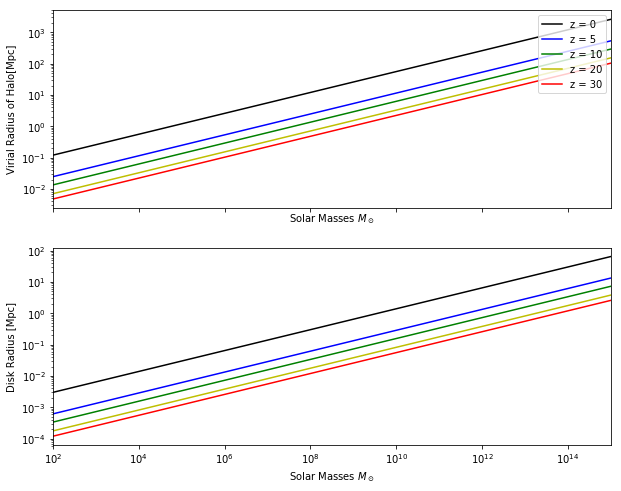

In [11]:
def om_m_z(z): 
    return((om_m * (1+z)**3)/((om_m * (1+z)**3) + om_lam + om_k * (1+z)**2))
def d(z):
    return(om_m_z(z) - 1)

def del_crit(z):
    return(18*np.pi**2 + 82 * d(z) - 39* d(z)**2)

def vir_r(M,z):
    mass_term = ((M)/(10**8 * h**(-1)))**(1/3)
    density_term = (om_m * del_crit(z))/(om_m_z(z) * 18 * np.pi**2)
    redshift_term = ((1+z)/10)**(-1)
    return(0.784*mass_term*density_term**(-1/3)*redshift_term*h**(-1))

def vel_crit(M,z):
    return(((G*6.769e-38*M)/vir_r(M,z))**(1/2))

vir_r_z0 = [vir_r(em,0) for em in m]
vir_r_z5 = [vir_r(em,5) for em in m]
vir_r_z10 = [vir_r(em,10) for em in m]
vir_r_z20 = [vir_r(em,20) for em in m]
vir_r_z30 = [vir_r(em,30) for em in m]

disk_r_z0 = [r/40. for r in vir_r_z0]
disk_r_z5 = [r/40. for r in vir_r_z5]
disk_r_z10 = [r/40. for r in vir_r_z10]
disk_r_z20 = [r/40. for r in vir_r_z20]
disk_r_z30 = [r/40. for r in vir_r_z30]


fig, (ax1, ax2) = plt.subplots(2,1,figsize= (10,8),sharex=True)
ax1.semilogx(m,vir_r_z0,'k-',label='z = 0')
ax1.semilogx(m,vir_r_z5,'b-',label='z = 5')
ax1.semilogx(m,vir_r_z10,'g-',label='z = 10')
ax1.semilogx(m,vir_r_z20,'y-',label='z = 20')
ax1.semilogx(m,vir_r_z30,'r-',label='z = 30')
ax1.set_yscale("log")
ax1.legend(loc = 'upper right')
ax1.set_xlabel('Solar Masses $M_\odot$')
ax1.set_ylabel('Virial Radius of Halo[Mpc]')
ax1.margins(x=0)

ax2.semilogx(m,disk_r_z0,'k-',label='z = 0')
ax2.semilogx(m,disk_r_z5,'b-',label='z = 5')
ax2.semilogx(m,disk_r_z10,'g-',label='z = 10')
ax2.semilogx(m,disk_r_z20,'y-',label='z = 20')
ax2.semilogx(m,disk_r_z30,'r-',label='z = 30')
ax2.set_yscale("log")
ax2.set_xlabel('Solar Masses $M_\odot$')
ax2.set_ylabel('Disk Radius [Mpc]')
ax2.margins(x=0)



# 2)b) Angular Extent
The angular extent of an object is given by the expression for angular diamater distance. We can utilise the actual size calculated above, and rearrange the for the angular extent
$$ d_A = \frac{D}{\delta}  \Rightarrow \delta = \frac{D}{d_A}$$

We then pass in the true radius of the dark matter halo and the galaxy disk and then get the angular extent. 

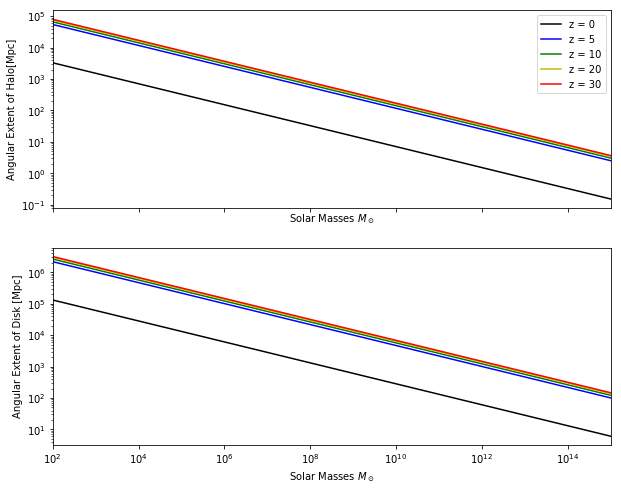

In [12]:
#Pass in Angular 
fig, (ax1, ax2) = plt.subplots(2,1,figsize= (10,8),sharex=True)
ax1.semilogx(m,r_em[1]/vir_r_z0,'k-',label='z = 0')
ax1.semilogx(m,r_em[50]/vir_r_z5,'b-',label='z = 5')
ax1.semilogx(m,r_em[100]/vir_r_z10,'g-',label='z = 10')
ax1.semilogx(m,r_em[200]/vir_r_z20,'y-',label='z = 20')
ax1.semilogx(m,r_em[299]/vir_r_z30,'r-',label='z = 30')
ax1.set_yscale("log")
ax1.legend(loc = 'upper right')
ax1.set_xlabel('Solar Masses $M_\odot$')
ax1.set_ylabel('Angular Extent of Halo[Mpc]')
ax1.margins(x=0)

ax2.semilogx(m,r_em[1]/disk_r_z0,'k-',label='z = 0')
ax2.semilogx(m,r_em[50]/disk_r_z5,'b-',label='z = 5')
ax2.semilogx(m,r_em[100]/disk_r_z10,'g-',label='z = 10')
ax2.semilogx(m,r_em[200]/disk_r_z20,'y-',label='z = 20')
ax2.semilogx(m,r_em[299]/disk_r_z30,'r-',label='z = 30')
ax2.set_yscale("log")
ax2.set_xlabel('Solar Masses $M_\odot$')
ax2.set_ylabel('Angular Extent of Disk [Mpc]')
ax2.margins(x=0)


# 3) Calculate and plot the minimum galaxy mass as a function of redshift. Note that by minimum galaxy mass we mean the minimum halo mass within which stars can form.

To calcualte the minimum galaxy mass, we can use the fact that in order for a cloud to collapse, its temperature must be approximately $10^4$ Kelvin. We can then use this to calculate the circular velocity of the cloud using 
$$T_{vir} = \frac{\mu m_p V_c^2}{2 k_B}$$
This can then be used to calcualte the mass using the equation
$$ v_c = \Big(\frac{G M }{r_{vir}}\Big)^{1/2} $$

Rearranging this using the expression for $r_{vir}$ from above yields
$$ m = \Big( \frac{2 k_B T_{vir} }{\mu m_p G} \Big)^{3/2} \Bigg( 0.784 \bigg( \frac{1}{10^8 h^{-1} }\bigg)^{1/3} \bigg[ \frac{\Omega_m}{\Omega_m^z} \frac{\Delta_{crit}}{18 \pi^2} \bigg] \bigg(\frac{1+z}{10} \bigg) h^{-1}  \Bigg)^{3/2}$$

In [13]:
t_vir = 10**4 
k_b = 1.45e-68 #kg Mpc^2 s^-2 K^-1
V_c = np.sqrt((2*k_b*t_vir)/(2*1.6726219e-27))

def vir_r_noM(z):
    mass_term = ((1)/(10**8 * h**(-1)))**(1/3)
    density_term = (om_m * del_crit(z))/(om_m_z(z) * 18 * np.pi**2)
    redshift_term = ((1+z)/10)**(-1)
    return(0.784*mass_term*density_term*redshift_term*h**(-1))

def min_mass(z):
    temp_term = ((2*k_b*t_vir)/(2*1.67e-27*G*6.769e-38))**(3/2) 
    vel_term = vir_r_noM(z)**(3/2)
    return(temp_term*vel_term * 10**(-3))
#min_mass = [((2 k_b t_vir)/(2*1.67e-27*G*6.769e-38))**(3/2)*(0.784*((1)/(10**8 * h**(-1)))**(1/3)*(om_m * del_crit(zed))/(om_m_z(zed) * 18 * np.pi**2)*((1+zed)/10)**(-1))**(3/2) for zed in z]



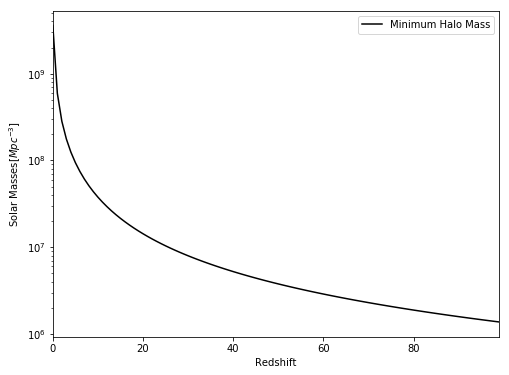

In [14]:
fig, ax = plt.subplots(figsize= (8,6))
ax.plot(z,min_mass(z),'k-',label='Minimum Halo Mass')
ax.set_yscale("log")
ax.legend(loc = 'upper right')
ax.set_xlabel('Redshift')
ax.set_ylabel('Solar Masses$[Mpc^{-3}]$')
ax.margins(x=0)


# 4) Calculate the total cross - section of galaxy disks on the sky by integrating over all redshifts  and  all  masses  above  the  minimum.  For  this  first  estimate  assume  that  all dark matter halos host a galaxy.

First we need to calculate the cross sectional area, which we can calculate using our expressions for the virial radius. Then we compute the value of the optical depth integrand, by multiplying the cross sectional area of a galaxy by the Press Schecter Mass function. We then multiply this by the scaled angular diameter distance, to scale the cross section. 
$$ c \frac{dt}{dz} \frac{dn_{gal}(z^\prime)}{dm} \sigma_{gal}(M,z^\prime)$$
We then integrate this from the minimum mass at a given redshift, up to the maximum mass. Ultimately however, this is impractical, since beyond a certain mass scale, there just aren't enough gravitationally bound masses, and the process of computing the integral will be from some minimum mass to some hypothetical infinite mass. This is self evident when we look at the Press Schecter Mass function, beyond about $10^{16}$, the number of virialised, bound halos drops to negligible amounts. 

Explicitly, in order to solve this, we need to perform the following operation:
$$ \tau _ { g a l } = \int _ { 0 } ^ { z } \int _ { M _ { \min } } ^ { \infty } d M d z ^ { \prime } \frac{c dt}{dz^\prime} \frac {d n _ { g a l } \left( z ^ { \prime } \right) } { d M } \sigma _ { g a l } ( M , z ) $$

Attempting to do this entirely analytically leads to long integration times, which the Python Integrator Quad struggles with, and since we end up not requiring the higher mass halos (due to their incredibly small fraction), it proves to be easier to populate a table with the value of the integrand, for a mass range between $[M_{min} , 10^{16} M_{\odot}]$, and for redshifts between $[0,19]$, since we don't expect many, if any, galaxies at high redshifts. 

This will, admittedly loose any galaxies which are truly massive, but given the likelyhood of them forming is incredibly low, their ultimate contribution to the optical depth will be very small. 

For this calculation, we have assumed that all dark matter halos will host a galaxy, and that all the galaxies are flat on the sky, with no crossing. 

In [15]:
def cross_section_vir(M,z):
    return(np.pi*vir_r(M,z)**2 * 10**(-6))

def cross_section_disk(M,z):
    return(np.pi*(vir_r(M,z)/40)**2 * 10**(-6))

def nu(M,z):
    r = ((3*M)/(4*np.pi*rho_m))**(1/3)
 #   print("r=" + str(r))

    var = D_t[z]*(const_s8*(1/(2*np.pi**2)*quad(sigma_integrand,0,np.inf,args=(r))[0])**(1/2))
    
    return(d_c(z)/(var))

def opt_depth_int_disk(M,z):
    dn_dm = -np.sqrt((2)/(np.pi))* rho_m/(M) * diff_term * nu(M,z)* np.exp(- (nu(M,z))**2/2)
    return(d_h(z)/(1+z)*press_schecter(M,z)*cross_section_disk(M,z)) 

#def bounds_m(m_min):
#    return([m_min,np.inf])

#def bounds_z(z):
#    return([0,z])

#Need Trapz Method, so need to create array of integrand, weighting early levels more than upper levels.


In [16]:
integ_lookup = np.ndarray(shape=(2,len(z[:20]),200))
#print(np.shape(integ_lookup))

In [17]:
#1st index = mass
#2nd index = redshift
#3rd index = 
for i in range(len(z[:20])):
    masses = np.logspace(np.log10(min_mass(i)),16,num=200)
#    print("z="+ str(i))
    for j in range(200):
      #  print("j="+str(j))
        integ_lookup[0][i][j] = masses[j]
        integ_lookup[1][i][j] = opt_depth_int_disk(masses[j],i)
    #print(type(i))
    #print(integ_lookup[i])


In [18]:
#print(integ_lookup[1][0][:])

In [19]:
second_integrand = [np.trapz(integ_lookup[1][zed][:],x=integ_lookup[0][zed][:]) for zed in z[:20]]
#print(second_integrand)
tau = np.trapz(second_integrand)   
print("The optical depth of galaxy disks is approximately = " +str(tau*100) + "%")


The optical depth of galaxy disks is approximately = 1.2928118797986756%


This is well within the realm of reasonable values, since if we count over the pixels in the Hubble Deep Field for a number of galaxies, it gives us a measure of $\approx 1\%$

In [20]:
#np.save("integrands_final",integ_lookup)

In [21]:
#test_array = np.load("integrands_final.npy")
#print(test_array)

# 5) 
We can improve the estimate by including the effects of Baryon Cooling in the Press Schecter Mass Function, which previously was only sensitive to angular momentum conservation. In practicality, the clouds in the Halo need enough time to cool appropriately to form stars, and so we need to consider these effects. If we say that the time it takes for the cloud to cool is $t_{cool}$, then there are three cases to consider:
* $t_{cool} > H^{-1}$: The Cloud won't cool, since it's cooling time is longer than the lifetime of the universe
* $t_{dyn} < t_{cool} < H^{-1} $: When the time to cool is longer than the time it takes for the cloud to free fall collapes $t_{dyn}$, but shorter than the lifetime of the universe, the cloud can technically collapse, however the pressure waves inside the cloud can provide a quasi-static pressure, which slows the collapse, so the collapse is considered 'slow'
* $t_{cool} < t_{dyn}$: In this case, the cloud can't respond dynamically to energy loss, and so will undergo direct collapse in an analogous manner to the Jeans Collapse. 

### Cooling Time $t_{cool}$
If we want a galaxy at the present day, we need a halo to collapse at redshift $z$ such that 
$$ t(z=0) - t(z) = t_{cool}(M,z)  = \frac{3 \rho k_B T_{vir}}{2 \mu \Lambda(T_{vir}) n^2} $$

This time can be found by the following expression
\begin{align*}
t_{\Lambda CDM}(z) = \int \frac{da }{H_0 a (\Omega_m a^{-3} + \Omega_\Lambda)^{1/2}}
\end{align*}

We then need to set up a root-finding algorithm, where we are finding the roots of the relationship $t(z=0) - t(z) - t_{cool}(M,z)=0$ 

After agonizing over the implementation of the one of the many numerous root finding algorithms in python, which require bounds on their solution space in order to work, and getting nowhere, I thought perhaps it would be possible to recast the problem as a least squares problem. If we square the left hand side of the above equation, we can minimise the difference, assuming that the initial collapse occured at the redshift measured plus 1. This will fail if the cloud doesn't have time to collapse. 

I am not sure whether my implementation is correct, but it will only correct the redshift by a very small margin.
<b> Tried it, it didn't work. </b> For some reason, this implementation doesn't actually affect the Press-Schechter at all. Back to the drawing board. 

The method of root finding utilised by Python involves the stating of the bounds over which the function is being analysed. The problem that I run into is that the left and right hand sides of the equation actually cross twice, so for each individual mass calculation, a separate range needs to be defined for the root finder. I have attempted to do this, but it has to be done by inspecting the crossing points of the two graphs visually, so it took longer than I anticipated, and so I have not completed it. I understand what needs to be done, and the methodology, I just needed more time to hone in on the ranges for a given mass range. 



In [22]:
def T_vir(M,z):
    r = vir_r(M,z)*10**(-3) #Mpc
    mu = 0.57 * 1.67e-27 #kg
    v_c = ((G*6.769e-38*M)/r)**(1/2) 
    numer = mu * v_c**2
    denom = 2 * k_b
    return(numer/denom)

def lam(M,z):
    a_0 = 5.2e-9 # Bohr Radius, defined in cm
    k = 8.61e-5 #Boltzmann Constant in eV/K
#    print(np.exp(13.6/(k*T)))
    denom = ((1+a_0*(T_vir(M,z)/(10**5))**(-7/6))*np.exp(13.6/(k*T_vir(M,z))))**2
#    print(denom)
    first = (10**(-24))/denom
#    print(first)
    second = 2.1* ((T_vir(M,z))/(10**5))**(-7/6) + 0.44 * ((T_vir(M,z))/(10**5))**(1/2)
   # print(second)
    return((first*second)*(10**(-13)))

def H(z):
    return(h_0*np.sqrt(om_m*(1+z)**3 + om_lam))
                    
def rho_crit_2(z):
    rho = (3*(H(z)*3.241e-20)**2)/(8*np.pi*G*6.769e-38)
    return(rho)


def t_cool(M,z):
    mu = 0.57 * 1.67e-27 # Mu defined in kgs
    k = 1.38e-23 #k_b in J/K
    n = 1
    rho = 18*np.pi**2*rho_crit_2(z) * 6.8*10**(-38)
    numer = 3* rho * k * T_vir(M,z)
    denom = 2 * mu * lam(M,z) * (n*10**6)**2
    #Expect 3e6 yrs for T=10^6 K
    # For years, divide by 3.154e7
    return(numer/(denom))


def t_z(z):
    a_z = 1/(1+z)
    result = (1/(h_0*(3.24*10**(-20))))*((2.10819*np.sqrt(0.428571/a_z**3 + 1)*a_z**(3/2)*np.arcsinh(1.52753*a_z**(3/2))))/(np.sqrt(7*a_z**(3)+3))
#    numer = 2 * a_z**(3/2)* np.sqrt(om_m * a_z**(-3) + om_lam) * np.log(a_z**(3/2) * om_lam + np.sqrt(om_lam)*np.sqrt(a_z**3*om_lam+om_m))
#    print(numer)
#    denom = 3 * np.sqrt(om_lam)* np.sqrt(a_z**3*om_lam+om_m) 
#    print(denom)
    return(result)

#Need to find z_col for a given Mass and redshift

def z_collapse(M,z):
    
    difference = lambda z_col: t_z(z) - t_z(z_col) - t_cool(M,z)
    
    upper = 20
    
    if M<10**5.5: return 1100 #Recombination indicates it won't have collapsed
    if 10**5.5<=M<10**5.7: 
        upper = 500
    if 10**5.7<=M<10**6: 
        upper = 350
    if 10**6<=M<10**6.5: 
        upper = 300
    if 10**6.5<=M<10**7:
        upper = 200
    if 10**7<=M<10**8: 
        upper = 50
    if 10**8<=M<10**13: 
        upper = 20
    if 10**13<=M<10**14:
        upper = 15
    if 10**14<=M<=10**14.7:    
        upper =13
#     print( upper)
    return(sp.optimize.bisect(difference,0,upper))
# Z Collapse Tests 
# z_collapse(10**10,1)

In [23]:
# z = np.arange(0,1000,1)
# fig, ax = plt.subplots(figsize= (8,6))
# ax.plot(z,t_z(0) - t_z(z),'r-')
# ax.plot(z,t_cool(10**10,z),'b-')
# ax.set_yscale("log")
# ax.set_xlabel('Redshift')
# ax.margins(x=0)


The next step is to utilise z_collapse to get a new measure for the overdensity, before once again passing it into the Press Schechter Mass Function. This subsequent process is not difficult, I have simply not managed to get the root finder working appropriately, so I cannot pass it through the function. 

In the code, the framework and functions are all there, they are just waiting on the root-finder to work. Display code at the top of the document, and you will see the implementation, it just needs tto be commented back in. 

In [24]:
def d_c_cool(M,z):
    z_col = z_collapse(M,z)
    return((1.69*(1+z_col))/D_t[z])

def press_schecter_cooled(M,z):
    
    r = ((3*M)/(4*np.pi*rho_m))**(1/3)
 #   print("r=" + str(r))

    var = (const_s8*(1/(2*np.pi**2)*quad(sigma_integrand,0,np.inf,args=(r))[0])**(1/2))
  #  print("var=" + str(var))
    second_m = 1.1*M
   # print("second_m="+str(second_m))
    second_r  = ((3*second_m)/(4*np.pi*rho_m))**(1/3)
   # print("second_r="+str(second_r))
    #Calcualte variance at 1.1m 
    var_1pt1 = (const_s8*(1/(2*np.pi**2)*quad(sigma_integrand,0,np.inf,args=(second_r))[0])**(1/2))
   # print("var1pt1="+str(var_1pt1))
    #Compute Differential Term
    diff_term = (np.log(var_1pt1) - np.log(var))/(second_m-M)
   # print("diff_term="+str(diff_term))
    #Compute the Nu values for various redshifts
    nu = d_c_cooled(M,z)/var
   # print("nu="+str(nu))
    #Compute the ratio of masses 
    dn_dm = -np.sqrt((2)/(np.pi))* rho_m/(M) * diff_term * nu* np.exp(- (nu)**2/2)
    return(dn_dm)

# #Compute the Nu values for various redshifts
# nu_z0_cool = d_c_cool(0)/var_z_0
# nu_z5_cool = d_c_cool(5)/var_z_0
# nu_z10_cool = d_c_cool(10)/var_z_0
# nu_z20_cool = d_c_cool(20)/var_z_0
# nu_z30_cool = d_c_cool(30)/var_z_0

# #Compute the ratio of masses 
# dn_dm_z0_cool = -np.sqrt((2)/(np.pi))* rho_m/(m) * diff_term * nu_z0* np.exp(- (nu_z0)**2/2)
# dn_dm_z5_cool = -np.sqrt((2)/(np.pi))* rho_m/(m) * diff_term * nu_z5* np.exp(- (nu_z5)**2/2)
# dn_dm_z10_cool = -np.sqrt((2)/(np.pi))* rho_m/(m) * diff_term * nu_z10* np.exp(- (nu_z10)**2/2)
# dn_dm_z20_cool = -np.sqrt((2)/(np.pi))* rho_m/(m) * diff_term * nu_z20* np.exp(- (nu_z20)**2/2)
# dn_dm_z30_cool = -np.sqrt((2)/(np.pi))* rho_m/(m) * diff_term * nu_z30* np.exp(- (nu_z30)**2/2)

# fig, ax = plt.subplots(figsize= (8,6))
# plt.ylim(1e-7,1e7)
# ax.semilogx(m,m*dn_dm_z0_cool-m*dn_dm_z0,'k-',label='z = 0')
# #ax.semilogx(m,m*dn_dm_z5_cool,'b-',label='z = 5')
# #ax.semilogx(m,m*dn_dm_z10_cool,'g-',label='z = 10')
# #ax.semilogx(m,m*dn_dm_z20_cool,'y-',label='z = 20')
# #ax.semilogx(m,m*dn_dm_z30_cool,'r-',label='z = 30')
# ax.set_yscale("log")
# ax.legend(loc = 'upper right')
# ax.set_xlabel('Solar Masses $M_\odot$')
# ax.set_ylabel('$m*dn/dm [Mpc^{-3}]$')
# ax.margins(x=0)


In [25]:
def opt_depth_int_disk_cooled(M,z):
    dn_dm = -np.sqrt((2)/(np.pi))* rho_m/(M) * diff_term * nu(M,z)* np.exp(- (nu(M,z))**2/2)
    return(d_h(z)/(1+z)*press_schecter_cooled(M,z)*cross_section_disk(M,z)) 

In [26]:
# integ_lookup_cooled = np.ndarray(shape=(2,len(z[:20]),200))


In [27]:
# #1st index = mass
# #2nd index = redshift
# #3rd index = values
# for i in range(len(z[:20])):
#     masses = np.logspace(np.log10(min_mass(i)),16,num=200)
#     for j in range(200):
#         integ_lookup_cooled[0][i][j] = masses[j]
#         integ_lookup_cooled[1][i][j] = opt_depth_int_disk(masses[j],i)



In [28]:
# second_integrand_cooled = [np.trapz(integ_lookup_cooled[1][zed][:],x=integ_lookup_cooled[0][zed][:]) for zed in z[:20]]
# #print(second_integrand)
# tau_cooled = np.trapz(second_integrand_cooled)   
# print("The optical depth of galaxy disks when Baryon Cooling is accounted for is approximately = " +str(tau*100) + "%")


# Conclusion
We expect that the modified Press Schechter function will exhibit a turnover at galaxy masses of about $10^8 M_{\odot}$, so it will have a simillar shape to the unmodified Press Schechter function, but shifted down and to the right. However, when you propogate this through to the optical depth calculation, it shouldn't actually change that much. 

Given that our optical depth calculation already considers masses of galaxies from the minimum mass that can form, which corresponds to about $10^9 M_{\odot} $, we expect that the few galaxies which are smaller than this will have negligible angular extent, and so not contribute greatly to the optical depth of galaxies. 

Therefore, to a first order, simply taking the Press Schechter Mass function on its own is enough to approximate the number of galaxies we expect to see on the sky, even with all the assumptions regarding location, orientation, and the galaxy to halo ratio. 